In [2]:
import pandas as pan
import os

# x1 = lat, x2 = long, y = biome
dirx = 'processed_data'
lat_long_df = pan.DataFrame(columns=["lat", "long", "biome"]) 
for root, dirs, files in os.walk(dirx):
    for filename in files:
        split = filename.split('_')
        if len(split) >= 2:
            lat = float(split[0])
            long = float(split[1][0:len(split[1])-4])
            biome = root[root.find('\\')+1:len(root)]
            row = {'lat': lat, 'long': long, 'biome': biome}
            lat_long_df = lat_long_df.append(row, ignore_index = True)
        else:
            print("Failed to parse filename: ", filename)

In [3]:
lat_long_norm = lat_long_df.join(pan.get_dummies(lat_long_df['biome'])).drop(columns='biome')

,lat,long,desert,forest,grassland,tundra
0,0.376893,0.279566,1.0,0.0,0.0,0.0
1,0.353752,0.853177,1.0,0.0,0.0,0.0
2,0.347168,0.288281,1.0,0.0,0.0,0.0
3,0.343450,0.872351,1.0,0.0,0.0,0.0
4,0.337647,0.863677,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1111,0.998573,0.286685,0.0,0.0,0.0,1.0
1112,0.998619,0.288930,0.0,0.0,0.0,1.0
1113,0.998941,0.287535,0.0,0.0,0.0,1.0
1114,0.999129,0.288753,0.0,0.0,0.0,1.0


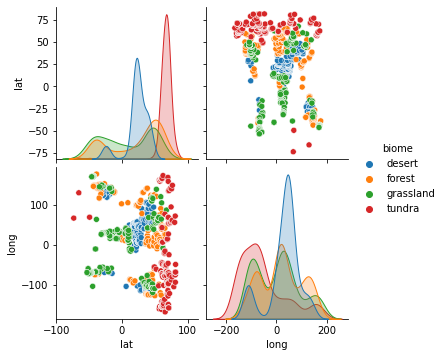

In [4]:
from sklearn.preprocessing import MinMaxScaler as mms
import seaborn as sns

lat_long_norm = (lat_long_norm-lat_long_norm.min())/(lat_long_norm.max()-lat_long_norm.min())
sns.pairplot(lat_long_df, hue = "biome")
lat_long_norm

## **Neural Network Interpretation**

In [7]:
import tensorflow as tf

coord_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=2,activation="tanh"), #,activity_regularizer=tf.keras.regularizers.L2(0.01)
    #tf.keras.layers.Dense(units=8,activation="tanh"),
    tf.keras.layers.Dense(units=4,activation="sigmoid")
])
coord_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5),loss=tf.losses.CategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

In [8]:
coord_model.fit(
    x=lat_long_norm.iloc[:,0:2],
    y=lat_long_norm.iloc[:,2:6],
    epochs = 500,
    verbose = 1,
    batch_size = 256
)

Epoch 1/500
5/5 [==============================] - 2s 5ms/step - loss: 1.4727 - accuracy: 0.2518
Epoch 2/500
5/5 [==============================] - 0s 5ms/step - loss: 1.3944 - accuracy: 0.3468
Epoch 3/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3801 - accuracy: 0.3056
Epoch 4/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3726 - accuracy: 0.2939
Epoch 5/500
5/5 [==============================] - 0s 5ms/step - loss: 1.3669 - accuracy: 0.2912
Epoch 6/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3622 - accuracy: 0.2975
Epoch 7/500
5/5 [==============================] - 0s 5ms/step - loss: 1.3572 - accuracy: 0.3020
Epoch 8/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3522 - accuracy: 0.3253
Epoch 9/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3468 - accuracy: 0.3271
Epoch 10/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3410 - accuracy: 0.3369
Epoch 11/500
5/5 [===========

KeyboardInterrupt: 

## **SVM Interpretation**

In [5]:
from sklearn.metrics import classification_report as report
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn import svm
import numpy as np

svm_df = lat_long_df.copy()
num_cats = []
for x in svm_df['biome']:
    if x == 'desert':
        num_cats.append(0)
    elif x == 'forest':
        num_cats.append(1)
    elif x == 'grassland':
        num_cats.append(2)
    elif x == 'tundra':
        num_cats.append(3)
svm_df = svm_df.drop(columns='biome')
#svm_df = (svm_df-svm_df.min())/(svm_df.max()-svm_df.min())
svm_df = svm_df.join(pan.DataFrame(num_cats, columns=['biome']))
train_in, test_in, train_out, test_out = tts(svm_df.iloc[:,0:2],svm_df.iloc[:,2:6],test_size=0.1)

# Now we will develop an rbf machine:
sample = np.ravel(train_out)
rbf_machine = svm.SVC(decision_function_shape='ovo', kernel="rbf", C=10)
rbf_machine.fit(train_in, sample)
pred_rbf = rbf_machine.predict(test_in)
rbf_stats = report(test_out, pred_rbf, target_names=["desert","forest","grassland","tundra"])
print("Report for rbf SVM: \n" + rbf_stats)
cv_score = cvs(rbf_machine, svm_df.iloc[:,0:2], svm_df.iloc[:,2], cv=10)
print("Average score from 10-fold CV: " + str(round(cv_score.mean(),3)))

Report for rbf SVM: 
              precision    recall  f1-score   support

      desert       0.84      0.91      0.87        34
      forest       0.64      0.74      0.68        19
   grassland       0.84      0.72      0.78        36
      tundra       0.95      0.91      0.93        23

    accuracy                           0.82       112
   macro avg       0.82      0.82      0.82       112
weighted avg       0.83      0.82      0.82       112

Average score from 10-fold CV: 0.746


As suspected, the support vector machine has the most trouble differentiating between forest and grassland, whereas the precision and recall on desert and tundra is very high.

## **World-map plot of RBF Machine:**

C:\Users\rstea_nzkrq5m\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


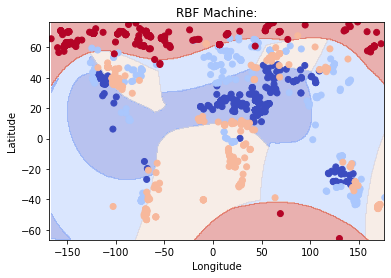

In [6]:
import matplotlib.pyplot as plt

h = 0.5 # step size for color grid
lat_min, lat_max = svm_df.iloc[:,0].min(), svm_df.iloc[:,0].max() # latitude
long_min, long_max = svm_df.iloc[:,1].min(), svm_df.iloc[:,1].max() # longitude
lat_steps, long_steps = np.meshgrid(np.arange(lat_min, lat_max, h), np.arange(long_min, long_max, h))
colors = rbf_machine.predict(np.c_[lat_steps.ravel(), long_steps.ravel()]).reshape(lat_steps.shape)
# Now we build the plot using matplotlib:
plt.contourf(long_steps, lat_steps, colors, cmap=plt.cm.coolwarm, alpha=0.4)
plt.scatter(svm_df.iloc[:,1], svm_df.iloc[:,0], c=svm_df.iloc[:,2], cmap=plt.cm.coolwarm)
plt.xlim(lat_steps.min()-95, lat_steps.max()+95)
plt.ylim(long_steps.min()+100, long_steps.max()-100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("RBF Machine:")
plt.show()

## **LogReg Interpretation**

In [33]:
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.metrics import classification_report as report
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV


x_in, y_in, x_out, y_out = tts(lat_long_df.iloc[:,0:2], lat_long_df.iloc[:,2],test_size=0.2)
log_model = logreg(penalty='none').fit(x_in, x_out)
log_pred = log_model.predict(y_in)
log_stats = report(y_out, log_pred, labels=['desert','forest','grassland','tundra'])
print("Report for LogReg: \n" + log_stats)

Report for LogReg: 
              precision    recall  f1-score   support

      desert       0.52      0.58      0.55        62
      forest       0.14      0.06      0.08        52
   grassland       0.44      0.60      0.51        53
      tundra       0.85      0.91      0.88        57

    accuracy                           0.55       224
   macro avg       0.49      0.54      0.51       224
weighted avg       0.50      0.55      0.52       224



## **Exporting the Results**

In [5]:
from sklearn.metrics import classification_report as report
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import numpy as np

svm_df = lat_long_df.copy()
num_cats = []
for x in svm_df['biome']:
    if x == 'desert':
        num_cats.append(0)
    elif x == 'forest':
        num_cats.append(1)
    elif x == 'grassland':
        num_cats.append(2)
    elif x == 'tundra':
        num_cats.append(3)
svm_df = svm_df.drop(columns='biome')
svm_df = svm_df.join(pan.DataFrame(num_cats, columns=['biome']))
train_in, test_in, train_out, test_out = tts(svm_df.iloc[:,0:2],svm_df.iloc[:,2:6],test_size=0.2)
sample = np.ravel(train_out)
export_svm_df = pan.DataFrame(columns=['desert','forest','grassland','tundra'])
rbf_machine = svm.SVC(decision_function_shape='ovo', kernel="rbf")
rbf_machine.fit(train_in, sample)
exp_pred_rbf = rbf_machine.predict(svm_df.iloc[:,0:2])
for x in exp_pred_rbf:
    if x == 0:
        row = {'desert': 1, 'forest': 0, 'grassland': 0, 'tundra': 0}
        export_svm_df = export_svm_df.append(row, ignore_index=True)
    elif x == 1:
        row = {'desert': 0, 'forest': 1, 'grassland': 0, 'tundra': 0}
        export_svm_df = export_svm_df.append(row, ignore_index=True)
    elif x == 2:
        row = {'desert': 0, 'forest': 0, 'grassland': 1, 'tundra': 0}
        export_svm_df = export_svm_df.append(row, ignore_index=True)
    elif x == 3:
        row = {'desert': 0, 'forest': 0, 'grassland': 0, 'tundra': 1}
        export_svm_df = export_svm_df.append(row, ignore_index=True)
export_svm_df.to_csv('svm_predictions.csv', index=False)
export_svm_df

,desert,forest,grassland,tundra
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
1111,0,0,0,1
1112,0,0,0,1
1113,0,0,0,1
1114,0,0,0,1


## **Export the Model**

In [11]:
import joblib as model_export

model_export.dump(rbf_machine, '.\\saved_models\\model_2.pkl')
model_2 = model_export.load('.\\saved_models\\model_2.pkl')
pred_2 = model_2.predict(test_in)
rbf_stats = report(test_out, pred_rbf, target_names=["desert","forest","grassland","tundra"])
print(rbf_stats)

              precision    recall  f1-score   support

      desert       0.81      0.90      0.85        60
      forest       0.64      0.68      0.66        60
   grassland       0.82      0.62      0.70        50
      tundra       0.91      0.93      0.92        54

    accuracy                           0.79       224
   macro avg       0.79      0.78      0.78       224
weighted avg       0.79      0.79      0.78       224

